<a href="https://colab.research.google.com/github/lotrmay/TensorFlow_Learning/blob/master/bc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   Odds_firstTeam  Odds_secondTeam  ...  playerBEKD  playerBEGrenadeDmg
0            2.20             1.62  ...      0.8800               3.700
1            1.45             2.50  ...      1.0175               3.575

[2 rows x 98 columns]
[[1.         1.         1.         0.95714286 1.         0.95714286
  1.         0.84210526 1.         0.94202899 1.         1.
  0.91262136 0.97058824 1.         1.         1.         1.
  0.95555556 1.         0.89719626 0.95384615 0.97183099 1.
  0.69090909 0.97222222 1.         0.83018868 0.65116279 1.
  0.96296296 1.         1.         0.98611111 1.         0.86486486
  1.         1.         0.83636364 1.         0.84175532 0.92753623
  0.99115044 1.         1.         1.         0.71493213 0.91891892
  1.         1.         1.         0.97014925 1.         0.12244898
  1.         0.98461538 1.         0.80397022 0.97997497 0.8915212
  1.         1.         1.         0.875      0.95454545 1.
  0.648      0.95588235 1.         0.92647059 1.      

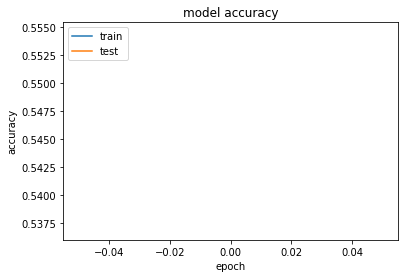

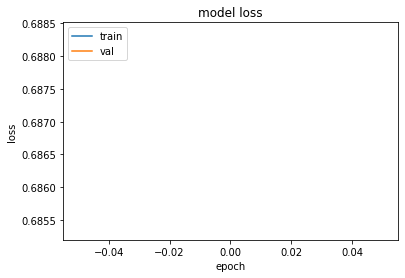

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from __future__ import absolute_import, division, print_function, unicode_literals
from sklearn.model_selection import train_test_split

import numpy as np #better arrays in python, lepší práce s multidimenzionálními poli
import pandas as pd #data analytics tool, lepší manipulace s daty, dokáže například cut outnout column
import matplotlib.pyplot as plt #vizualizace tabulek a grafů
from IPython.display import clear_output #jen pro tenhle notebook
from six.moves import urllib
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import utils as np_utils
import matplotlib.pyplot as plt
import numpy
import keras
CSV_COLUMN_NAMES=['Odds_firstTeam','Odds_secondTeam','Rank_firstTeam','Rank_secondTeam','WinRate_firstTeam','WinRate_secondTeam','PistolWinRate_firstTeam','PistolWinRate_secondTeam',
                  'playerAARating','playerAADpr','playerAAKast','playerAAImpact','playerAAAdr','playerAAKpr','playerAAHs','playerAAKD','playerAAGrenadeDmg',
                  'playerABRating','playerABDpr','playerABKast','playerABImpact','playerABAdr','playerABKpr','playerABHs','playerABKD','playerABGrenadeDmg',
                  'playerACRating','playerACDpr','playerACKast','playerACImpact','playerACAdr','playerACKpr','playerACHs','playerACKD','playerACGrenadeDmg',
                  'playerADRating','playerADDpr','playerADKast','playerADImpact','playerADAdr','playerADKpr','playerADHs','playerADKD','playerADGrenadeDmg',
                  'playerAERating','playerAEDpr','playerAEKast','playerAEImpact','playerAEAdr','playerAEKpr','playerAEHs','playerAEKD','playerAEGrenadeDmg',
                  'playerBARating','playerBADpr','playerBAKast','playerBAImpact','playerBAAdr','playerBAKpr','playerBAHs','playerBAKD','playerBAGrenadeDmg',
                  'playerBBRating','playerBBDpr','playerBBKast','playerBBImpact','playerBBAdr','playerBBKpr','playerBBHs','playerBBKD','playerBBGrenadeDmg',
                  'playerBCRating','playerBCDpr','playerBCKast','playerBCImpact','playerBCAdr','playerBCKpr','playerBCHs','playerBCKD','playerBCGrenadeDmg',
                  'playerBDRating','playerBDDpr','playerBDKast','playerBDImpact','playerBDAdr','playerBDKpr','playerBDHs','playerBDKD','playerBDGrenadeDmg',
                  'playerBERating','playerBEDpr','playerBEKast','playerBEImpact','playerBEAdr','playerBEKpr','playerBEHs','playerBEKD','playerBEGrenadeDmg','Match_link','Result','team_one_name','team_two_name']
RESULTS=['0','1']
CSV_COLUMN_NAMES_WITHOUT_STRINGS=['Odds_firstTeam','Odds_secondTeam','Rank_firstTeam','Rank_secondTeam','WinRate_firstTeam','WinRate_secondTeam','PistolWinRate_firstTeam','PistolWinRate_secondTeam',
                  'playerAARating','playerAADpr','playerAAKast','playerAAImpact','playerAAAdr','playerAAKpr','playerAAHs','playerAAKD','playerAAGrenadeDmg',
                  'playerABRating','playerABDpr','playerABKast','playerABImpact','playerABAdr','playerABKpr','playerABHs','playerABKD','playerABGrenadeDmg',
                  'playerACRating','playerACDpr','playerACKast','playerACImpact','playerACAdr','playerACKpr','playerACHs','playerACKD','playerACGrenadeDmg',
                  'playerADRating','playerADDpr','playerADKast','playerADImpact','playerADAdr','playerADKpr','playerADHs','playerADKD','playerADGrenadeDmg',
                  'playerAERating','playerAEDpr','playerAEKast','playerAEImpact','playerAEAdr','playerAEKpr','playerAEHs','playerAEKD','playerAEGrenadeDmg',
                  'playerBARating','playerBADpr','playerBAKast','playerBAImpact','playerBAAdr','playerBAKpr','playerBAHs','playerBAKD','playerBAGrenadeDmg',
                  'playerBBRating','playerBBDpr','playerBBKast','playerBBImpact','playerBBAdr','playerBBKpr','playerBBHs','playerBBKD','playerBBGrenadeDmg',
                  'playerBCRating','playerBCDpr','playerBCKast','playerBCImpact','playerBCAdr','playerBCKpr','playerBCHs','playerBCKD','playerBCGrenadeDmg',
                  'playerBDRating','playerBDDpr','playerBDKast','playerBDImpact','playerBDAdr','playerBDKpr','playerBDHs','playerBDKD','playerBDGrenadeDmg',
                  'playerBERating','playerBEDpr','playerBEKast','playerBEImpact','playerBEAdr','playerBEKpr','playerBEHs','playerBEKD','playerBEGrenadeDmg']



train=pd.read_csv('/content/pokus.csv',sep=";",names=CSV_COLUMN_NAMES,error_bad_lines=False,header=None)
prediction=pd.read_csv('/content/predikce.csv',sep=",",names=CSV_COLUMN_NAMES_WITHOUT_STRINGS,error_bad_lines=False,header=None)
#print(prediction.head())
#shufflnout data?
#train_y=train.pop('Result')
#test_y=test.pop('Result')
train.pop('Match_link')
train.pop('team_one_name')
train.pop('team_two_name')
target_column = ['Result'] 
predictors = list(set(list(train.columns))-set(target_column))
train[predictors] = train[predictors]/train[predictors].max()# použít tohle na predikci????
#prediction[predictors] = prediction[predictors]/prediction[predictors].max()

#Xnew=prediction[predictors].values
#print(Xnew)
X = train[predictors].values
y = train[target_column].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=35)
print(X_train.shape); print(X_test.shape)
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
count_classes = y_test.shape[1]


model = Sequential()
model.add(Dense(98, activation='relu'))
model.add(Dense(28, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

#categorical_crossentropy
# categorical_hinge 0.677
# hinge 0.667
# MeanAbsoluteError 0.654, ale do 1500 epochs to bylo nad 0.67
# MeanAbsolutePercentageError 0.6814 nevyskytuje se snížení po 1500 epochs jako minule
history = model.fit(X_train, y_train, epochs=1,batch_size=32,validation_data=(X_test, y_test))

pred_train= model.predict(X_train)
scores = model.evaluate(X_train, y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test= model.predict(X_test)



scores2 = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
Xnew=np.array([[1.65,2.1,25.0,40.0,0.56,0.56,0.55,0.512,1.17,0.62,0.71,1.25,77.1,0.75,0.32,1.20,5.7,1.09,0.61,0.74,0.95,74.3,0.66,0.43,1.09,7.9,1.05,0.69,0.68,1.12,75.3,0.66,0.58,0.96,6.9,1.04,0.66,0.7,1.05,72.4,0.65,0.63,0.98,5.3,1.02,0.65,0.7,0.95,70.3,0.64,0.53,0.99,4.4,1.1,0.67,0.71,1.14,77.8,0.71,0.54,1.06,6.2,1.06,0.66,0.71,0.99,76.6,0.69,0.51,1.04,4.6,1.03,0.69,0.72,0.98,74.1,0.67,0.53,0.96,4.5,0.96,0.72,0.68,0.98,72.2,0.59,0.42,0.82,7.1,1.0375,0.685,0.705,1.0225,75.175,0.665,0.5,0.97,5.6],
                [2.2,1.62,17,6,0.65,0.46,0.474,0.492,1.1,0.67,0.71,1.12,78.3,0.69,0.52,1.04,5.2,1.09,0.64,0.72,1.06,76.2,0.69,0.53,1.08,4.3,1.05,0.63,0.73,0.94,73.3,0.64,0.38,1.02,6.8,1.02,0.65,0.7,0.97,68.9,0.65,0.44,1.00,3.2,1.065,0.6475,0.7150000000000001,1.0225,74.17500000000001,0.6675,0.4675,1.0350000000000001,4.875,1.13,0.56,0.71,1.05,71.5,0.71,0.25,1.26,5.0,1.05,0.64,0.7,0.96,76.0,0.65,0.57,1.02,5.8,0.99,0.76,0.66,1.14,75.9,0.63,0.62,0.83,2.8,0.98,0.64,0.69,0.91,67.7,0.62,0.46,0.96,3.7,0.92,0.65,0.67,0.81,63.3,0.58,0.6,0.88,3.7],
                [1.45,2.5,38,49,0.47,0.55,0.663,0.457,1.07,0.7,0.68,1.13,79.9,0.71,0.54,1.01,4.9,1.05,0.65,0.7,1.02,71.6,0.66,0.26,1.02,4.5,1.03,0.68,0.7,1.03,72.9,0.69,0.55,1.02,2.1,0.94,0.69,0.68,0.9,68.3,0.61,0.53,0.88,3.8,0.93,0.69,0.67,0.9,70.0,0.6,0.49,0.86,4.6,1.11,0.64,0.71,1.03,80.2,0.72,0.47,1.12,3.1,1.1,0.62,0.72,1.07,73.5,0.68,0.28,1.11,3.9,1.02,0.7,0.69,1.02,74.1,0.66,0.59,0.94,4.3,0.97,0.72,0.68,0.91,73.0,0.65,0.53,0.90,3.0,1.05,0.6699999999999999,0.7000000000000001,1.0075,75.19999999999999,0.6775,0.46749999999999997,1.0175,3.575],
                [1.8,1.92,32,28,0.58,0.62,0.449,0.535,1.25,0.59,0.78,1.17,84.8,0.77,0.5,1.30,7.6,1.15,0.61,0.72,1.15,76.9,0.73,0.21,1.20,3.7,1.08,0.67,0.73,1.07,77.3,0.66,0.43,0.99,5.2,1.06,0.63,0.74,0.97,71.2,0.64,0.52,1.02,5.4,1.02,0.66,0.7,1.03,69.2,0.64,0.45,0.97,3.8,1.19,0.68,0.73,1.28,85.8,0.76,0.6,1.12,5.3,1.09,0.61,0.7,1.08,70.1,0.71,0.28,1.17,3.5,1.07,0.66,0.72,1.04,75.4,0.69,0.54,1.04,3.2,1.06,0.63,0.71,1.0,70.8,0.66,0.61,1.05,4.0,0.91,0.68,0.67,0.8,67.1,0.56,0.51,0.83,6.7],
                [1.5,2.5,23,36,0.65,0.43,0.591,0.537,1.22,0.61,0.76,1.13,81.8,0.8,0.53,1.31,3.5,1.2,0.6,0.75,1.22,77.0,0.75,0.33,1.25,3.2,1.15,0.63,0.73,1.14,77.3,0.73,0.49,1.15,5.1,1.02,0.68,0.71,1.01,71.8,0.63,0.51,0.93,4.1,0.99,0.68,0.69,0.96,71.3,0.6,0.48,0.89,5.1,1.16,0.65,0.7,1.19,78.9,0.78,0.28,1.20,2.6,1.09,0.61,0.72,0.99,76.5,0.68,0.37,1.11,5.1,1.05,0.7,0.68,1.14,77.5,0.7,0.47,1.01,3.1,0.98,0.69,0.69,0.89,72.0,0.63,0.53,0.91,5.9,0.87,0.69,0.65,0.84,60.6,0.55,0.54,0.80,3.8],
                [1.65,2.1,146,113,0.5,0.48,0.5,0.5,1.24,0.63,0.73,1.17,88.5,0.85,0.5,1.35,4.1,1.12,0.62,0.75,0.97,80.6,0.71,0.48,1.14,6.1,1.02,0.65,0.69,1.01,68.7,0.62,0.65,0.96,3.3,0.97,0.69,0.65,1.02,68.4,0.63,0.28,0.92,4.7,0.9,0.58,0.69,0.71,57.6,0.51,0.42,0.88,6.9,1.17,0.62,0.72,1.19,76.7,0.76,0.33,1.21,1.6,1.14,0.66,0.73,1.11,80.7,0.72,0.49,1.10,4.4,1.01,0.66,0.71,0.95,72.5,0.64,0.48,0.96,5.2,1.1066666666666665,0.6466666666666666,0.7200000000000001,1.0833333333333333,76.63333333333334,0.7066666666666667,0.43333333333333335,1.09,3.733333333333333,1.1066666666666665,0.6466666666666666,0.7200000000000001,1.0833333333333333,76.63333333333334,0.7066666666666667,0.43333333333333335,1.09,3.733333333333333],
                [2.5,1.47,52,16,0.44,0.65,0.551,0.496,1.15,0.62,0.71,1.19,75.5,0.74,0.27,1.20,3.2,1.07,0.68,0.72,1.03,76.7,0.69,0.5,1.02,4.2,1.04,0.68,0.71,1.02,74.5,0.66,0.44,0.97,6.9,0.94,0.7,0.65,0.99,70.3,0.6,0.47,0.84,5.7,0.88,0.65,0.68,0.69,61.1,0.55,0.55,0.85,2.9,1.16,0.63,0.73,1.1,83.0,0.73,0.49,1.16,6.7,1.14,0.55,0.72,1.11,69.1,0.71,0.36,1.29,2.9,1.1,0.64,0.71,1.09,77.1,0.69,0.53,1.09,5.6,1.08,0.68,0.71,1.08,77.7,0.7,0.5,1.03,5.1,1.07,0.6,0.72,0.96,72.6,0.67,0.53,1.11,5.6],
                [1.6,2.3,1,2,0.83,0.68,0.569,0.5,1.24,0.49,0.78,1.13,73.9,0.73,0.27,1.49,3.9,1.21,0.59,0.73,1.25,79.4,0.74,0.5,1.26,5.0,1.18,0.61,0.74,1.18,79.5,0.72,0.47,1.18,5.7,1.1,0.71,0.69,1.27,79.1,0.69,0.48,0.97,6.2,0.95,0.56,0.75,0.66,58.1,0.52,0.52,0.91,5.1,1.3,0.58,0.76,1.31,86.3,0.82,0.37,1.42,1.6,1.14,0.56,0.73,1.08,72.2,0.72,0.66,1.27,4.5,1.12,0.65,0.72,1.11,81.5,0.71,0.5,1.09,5.0,1.04,0.57,0.76,0.83,68.2,0.59,0.49,1.05,5.1,0.91,0.66,0.7,0.81,63.3,0.53,0.35,0.81,4.5],
                [1.48,2.5,26,24,0.63,0.56,0.513,0.5,1.16,0.68,0.69,1.27,84.9,0.75,0.51,1.10,7.2,1.12,0.65,0.71,1.1,77.6,0.72,0.58,1.10,2.9,0.99,0.66,0.69,0.94,67.3,0.61,0.58,0.93,3.4,0.98,0.67,0.7,0.91,68.3,0.61,0.58,0.92,4.2,1.0625,0.665,0.6975,1.055,74.525,0.6725,0.5625,1.0125000000000002,4.425,1.14,0.63,0.7,1.21,75.1,0.74,0.31,1.17,1.4,1.11,0.67,0.7,1.12,82.3,0.73,0.49,1.08,7.5,1.04,0.69,0.67,1.07,77.8,0.7,0.62,1.02,4.4,0.84,0.67,0.65,0.75,60.5,0.51,0.49,0.76,6.5,1.0325,0.665,0.6799999999999999,1.0375,73.925,0.6699999999999999,0.4775,1.0075,4.95],
                [1.45,2.6,17,25,0.65,0.56,0.474,0.55,1.1,0.67,0.71,1.12,78.3,0.69,0.52,1.04,5.2,1.09,0.64,0.72,1.06,76.2,0.69,0.53,1.08,4.3,1.05,0.63,0.73,0.94,73.3,0.64,0.38,1.02,6.8,1.02,0.65,0.7,0.97,68.9,0.65,0.44,1.00,3.2,1.065,0.6475,0.7150000000000001,1.0225,74.17500000000001,0.6675,0.4675,1.0350000000000001,4.875,1.17,0.62,0.71,1.25,77.1,0.75,0.32,1.20,5.7,1.09,0.61,0.74,0.95,74.3,0.66,0.43,1.09,7.9,1.05,0.69,0.68,1.12,75.3,0.66,0.58,0.96,6.9,1.04,0.66,0.7,1.05,72.4,0.65,0.63,0.98,5.3,1.02,0.65,0.7,0.95,70.3,0.64,0.53,0.99,4.4]
               ])

#Xnew=np.zeros((2, 98))
print(X_test[1])
ynew=(model.predict([[1.65,2.1,25.0,40.0,0.56,0.56,0.55,0.512,1.17,0.62,0.71,1.25,77.1,0.75,0.32,1.20,5.7,1.09,0.61,0.74,0.95,74.3,0.66,0.43,1.09,7.9,1.05,0.69,0.68,1.12,75.3,0.66,0.58,0.96,6.9,1.04,0.66,0.7,1.05,72.4,0.65,0.63,0.98,5.3,1.02,0.65,0.7,0.95,70.3,0.64,0.53,0.99,4.4,1.1,0.67,0.71,1.14,77.8,0.71,0.54,1.06,6.2,1.06,0.66,0.71,0.99,76.6,0.69,0.51,1.04,4.6,1.03,0.69,0.72,0.98,74.1,0.67,0.53,0.96,4.5,0.96,0.72,0.68,0.98,72.2,0.59,0.42,0.82,7.1,1.0375,0.685,0.705,1.0225,75.175,0.665,0.5,0.97,5.6]]))

print(ynew)

[0.42995169 0.53       0.6351626  0.62105263 0.61306533 0.75531915
 0.14423077 0.23837209 0.62198391 0.62       0.47674419 0.24
 0.5989011  0.64088398 0.28406467 0.73021277 0.47849462 0.17061611
 0.4047619  0.63       0.5437788  0.66981132 0.50714286 0.2748538
 0.33       0.75       0.16738197 0.50561798 0.10714286 0.74
 0.45       0.56       0.73       0.53333333 0.62352941 0.408
 0.2        0.41979522 0.88       0.27319588 0.70588235 0.67592593
 0.41836735 0.60663507 0.8021978  0.49090909 0.73201693 0.31666667
 0.52244898 0.66272189 0.19       0.58       0.54054054 0.06410256
 0.125      0.66       0.65549348 0.59589041 0.57515879 0.58082575
 0.38576779 0.19333333 0.63354037 0.55       0.56872038 0.5645933
 0.04807692 0.53383459 0.79166667 0.6        0.62       0.625
 0.66380789 0.16101695 0.75789474 0.6718903  0.58       0.63584637
 0.66037736 0.60483871 0.73       0.26       0.69863014 0.59235669
 0.77894737 0.7968254  0.52       0.63428571 0.66       0.6125
 0.64324324 0.63535912 